In [4]:
import sys, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random


In [5]:
sys.path.append(
    "/Users/wiegerscheurer/repos/physicspred"
)  # To enable importing from repository folders


from functions.utilities import ordinal_sample

In [6]:
# def ordinal_sample(mean, step_size, n_factors, n_samples, plot:bool=False):
#     # steps = np.arange(0, (mean + (step_size * (n_factors // 2))), step_size)
#     steps = np.arange(mean, n_factors * step_size, step_size)
    
#     steps = steps - np.median(steps)
#     return steps
# # 
# ordinal_sample(1, 1, 5, 10)

import numpy as np

# def ordinal_sample(mean, step_size, n_elements, plot:bool=False):
#     # Calculate the start and end points
#     half_range = (n_elements - 1) // 2
#     start = mean - half_range * step_size
#     end = mean + half_range * step_size
    
#     # Generate the steps
#     steps = np.arange(start, end + step_size, step_size)
    
#     # Ensure the correct number of elements
#     if len(steps) > n_elements:
#         steps = steps[:n_elements]
    
#     return steps

# # Example usage
print(ordinal_sample(1, .5, 5))

[0.  0.5 1.  1.5 2. ]


In [7]:
from itertools import product


def create_balanced_trial_design(trial_n=None, change_ratio:list = [True, False], avg_ball_luminance=.45, natural_luminance_variance=0.05):
    
    def _clean_trial_options(df):
        # For each row, if trial_option starts with "none", keep only the first 6 characters
        df['trial_option'] = df['trial_option'].apply(
            lambda x: x[:6] if x.startswith('none_') else x
        )
        return df

    # Your options
    interactor_trial_options = ["45_top_r", "45_top_u", "45_bottom_l", "45_bottom_d",
                               "135_top_l", "135_top_u", "135_bottom_r", "135_bottom_d"]
    # empty_trial_options = ["none_l", "none_r", "none_u", "none_d"] * 2
    # Option 1: Create 8 truly unique empty trial options
    empty_trial_options = ["none_l_1", "none_r_1", "none_u_1", "none_d_1", 
                        "none_l_2", "none_r_2", "none_u_2", "none_d_2"]


    directions = ["left", "right"] * 8
    random.shuffle(directions)
    
    # Update the direction mapping
    direction_mapping = {
        "none_l_1": directions[0], "none_l_2": directions[1],
        "none_r_1": directions[2], "none_r_2": directions[3],
        "none_u_1": directions[4], "none_u_2": directions[5],
        "none_d_1": directions[6], "none_d_2": directions[7]
    }
    
    bounce_options = [True, False]
    # ball_change_options = [True, False]
    ball_change_options = change_ratio
    
    # ball_luminance_options = list(np.arange(
    #     avg_ball_luminance - natural_luminance_variance,
    #     avg_ball_luminance + (2 * natural_luminance_variance),
    #     natural_luminance_variance
    # ))[:3]  # Take only 3 luminances
    
    ball_luminance_options = list(ordinal_sample(avg_ball_luminance, natural_luminance_variance, n_elements=5, round_decimals=3))
    
    
    
    # If trial_n is specified, create a balanced subset
    if trial_n is not None:
        # Make sure trial_n is even for interactor:empty balance
        if trial_n % 2 == 1:
            trial_n -= 1
            print(f"Adjusted trial count to {trial_n} to maintain balance")
        
        half_n = trial_n // 2  # Half for interactor, half for empty
        
        # Create dataframe to store the balanced design
        all_trials = []
        
        # For interactor trials
        # First, create all possible combinations
        interactor_combos = list(product(
            interactor_trial_options,
            bounce_options,
            ball_change_options,
            ball_luminance_options
        ))
        random.shuffle(interactor_combos)  # Shuffle to avoid bias
        
        # Now intelligently select a subset that maximizes balance
        selected_interactor = []
        option_counts = {option: 0 for option in interactor_trial_options}
        bounce_counts = {True: 0, False: 0}
        change_counts = {True: 0, False: 0}
        luminance_counts = {luminance: 0 for luminance in ball_luminance_options}
        
        # First pass: try to get at least one of each option
        for option in interactor_trial_options:
            matching_combos = [c for c in interactor_combos if c[0] == option and c not in selected_interactor]
            if matching_combos:
                selected_interactor.append(matching_combos[0])
                option_counts[option] += 1
                bounce_counts[matching_combos[0][1]] += 1
                change_counts[matching_combos[0][2]] += 1
                luminance_counts[matching_combos[0][3]] += 1
        
        # Second pass: fill in remaining slots balancing bounce and ball_change
        remaining_slots = half_n - len(selected_interactor)
        while remaining_slots > 0:
            # Prioritize by least common option, then bounce, then ball_change
            min_option_count = min(option_counts.values())
            min_options = [opt for opt, count in option_counts.items() if count == min_option_count]
            
            min_bounce_count = min(bounce_counts.values())
            min_bounce = [b for b, count in bounce_counts.items() if count == min_bounce_count]
            
            min_change_count = min(change_counts.values())
            min_change = [c for c, count in change_counts.items() if count == min_change_count]
            
            # Find combos that match our criteria
            matching_combos = [c for c in interactor_combos 
                              if c[0] in min_options 
                              and c[1] in min_bounce 
                              and c[2] in min_change 
                              and c not in selected_interactor]
            
            # If no perfect match, relax constraints one by one
            if not matching_combos:
                matching_combos = [c for c in interactor_combos 
                                  if c[0] in min_options 
                                  and c[1] in min_bounce 
                                  and c not in selected_interactor]
            
            if not matching_combos:
                matching_combos = [c for c in interactor_combos 
                                  if c[0] in min_options 
                                  and c not in selected_interactor]
            
            if not matching_combos:
                matching_combos = [c for c in interactor_combos if c not in selected_interactor]
            
            if matching_combos:
                best_combo = matching_combos[0]
                selected_interactor.append(best_combo)
                option_counts[best_combo[0]] += 1
                bounce_counts[best_combo[1]] += 1
                change_counts[best_combo[2]] += 1
                luminance_counts[best_combo[3]] += 1
                remaining_slots -= 1
            else:
                # If we somehow run out of unique combinations
                break
        
        # Create the interactor trials from our selection
        for trial_option, bounce, ball_change, ball_luminance in selected_interactor:
            all_trials.append({
                'trial_type': 'interactor',
                'trial_option': trial_option,
                'bounce': bounce,
                'phant_bounce_direction': None,
                'ball_change': ball_change,
                'ball_luminance': ball_luminance
            })
        
        # For empty trials, use the same approach
        empty_combos = list(product(
            empty_trial_options,
            bounce_options,
            ball_change_options,
            ball_luminance_options
        ))
        random.shuffle(empty_combos)  # Shuffle to avoid bias
        
        # Now intelligently select a subset that maximizes balance
        selected_empty = []
        option_counts = {option: 0 for option in empty_trial_options}
        bounce_counts = {True: 0, False: 0}
        change_counts = {True: 0, False: 0}
        luminance_counts = {luminance: 0 for luminance in ball_luminance_options}
        
        # First pass: try to get at least one of each option
        for option in empty_trial_options:
            matching_combos = [c for c in empty_combos if c[0] == option and c not in selected_empty]
            if matching_combos:
                selected_empty.append(matching_combos[0])
                option_counts[option] += 1
                bounce_counts[matching_combos[0][1]] += 1
                change_counts[matching_combos[0][2]] += 1
                luminance_counts[matching_combos[0][3]] += 1
        
        # Second pass: fill in remaining slots balancing bounce and ball_change
        remaining_slots = half_n - len(selected_empty)
        while remaining_slots > 0:
            # Prioritize by least common option, then bounce, then ball_change
            min_option_count = min(option_counts.values())
            min_options = [opt for opt, count in option_counts.items() if count == min_option_count]
            
            min_bounce_count = min(bounce_counts.values())
            min_bounce = [b for b, count in bounce_counts.items() if count == min_bounce_count]
            
            min_change_count = min(change_counts.values())
            min_change = [c for c, count in change_counts.items() if count == min_change_count]
            
            # Find combos that match our criteria
            matching_combos = [c for c in empty_combos 
                              if c[0] in min_options 
                              and c[1] in min_bounce 
                              and c[2] in min_change 
                              and c not in selected_empty]
            
            # If no perfect match, relax constraints one by one
            if not matching_combos:
                matching_combos = [c for c in empty_combos 
                                  if c[0] in min_options 
                                  and c[1] in min_bounce 
                                  and c not in selected_empty]
            
            if not matching_combos:
                matching_combos = [c for c in empty_combos 
                                  if c[0] in min_options 
                                  and c not in selected_empty]
            
            if not matching_combos:
                matching_combos = [c for c in empty_combos if c not in selected_empty]
            
            if matching_combos:
                best_combo = matching_combos[0]
                selected_empty.append(best_combo)
                option_counts[best_combo[0]] += 1
                bounce_counts[best_combo[1]] += 1
                change_counts[best_combo[2]] += 1
                luminance_counts[best_combo[3]] += 1
                remaining_slots -= 1
            else:
                # If we somehow run out of unique combinations
                break
        
        # Create the empty trials from our selection
        for trial_option, bounce, ball_change, ball_luminance in selected_empty:
            bounce_direction = direction_mapping[trial_option] if bounce else None
            all_trials.append({
                'trial_type': 'empty',
                'trial_option': trial_option,
                'bounce': bounce,
                'phant_bounce_direction': bounce_direction,
                'ball_change': ball_change,
                'ball_luminance': ball_luminance
            })
        
        # Convert to dataframe and shuffle
        df = pd.DataFrame(all_trials)
        df.sample(frac=1).reset_index(drop=True)
        return _clean_trial_options(df)
    
    # If trial_n is None, create the full balanced design
    else:
        # Create all possible combinations
        all_trials = []
        
        # For interactor trials
        for combo in product(interactor_trial_options, bounce_options, ball_change_options, ball_luminance_options):
            trial_option, bounce, ball_change, ball_luminance = combo
            all_trials.append({
                'trial_type': 'interactor',
                'trial_option': trial_option,
                'bounce': bounce,
                'phant_bounce_direction': None,
                'ball_change': ball_change,
                'ball_luminance': ball_luminance
            })
        
        # For empty trials - we need to duplicate these to match interactor count
        for combo in product(empty_trial_options, bounce_options, ball_change_options, ball_luminance_options):
            trial_option, bounce, ball_change, ball_luminance = combo
            bounce_direction = direction_mapping[trial_option] if bounce else None
            
            # Each empty trial combination needs to appear twice to balance with interactor trials
            # for _ in range(2):
            all_trials.append({
                'trial_type': 'empty',
                'trial_option': trial_option,
                'bounce': bounce,
                'phant_bounce_direction': bounce_direction,
                'ball_change': ball_change,
                'ball_luminance': ball_luminance
            })
    
    
        # Convert to dataframe and shuffle
        df = pd.DataFrame(all_trials)

        df.sample(frac=1).reset_index(drop=True)
        
        return _clean_trial_options(df)
            
        # return output_df.sample(frac=1).reset_index(drop=True)
        
def build_design_matrix(n_trials:int, change_ratio:list=[True, False], avg_ball_luminance:float=.45, natural_luminance_variance:float=.05, trials_per_fullmx:int | None=None, verbose:bool=False):
    """
    Build a design matrix for a given number of trials.

    Parameters:
    - n_trials (int): The total number of trials.
    - verbose (bool): Whether to print verbose output.

    Returns:
    - design_matrix (pd.DataFrame): The resulting design matrix.
    """
    # trials_per_fullmx = 192
    if trials_per_fullmx is None:
        test_dm = create_balanced_trial_design(trial_n=None, 
                                               change_ratio=change_ratio, 
                                               avg_ball_luminance=avg_ball_luminance, 
                                               natural_luminance_variance=natural_luminance_variance)
        trials_per_fullmx = len(test_dm)    
        print(f"Number of trials per full matrix: {trials_per_fullmx}")

    full_matrices = n_trials // trials_per_fullmx
    remainder = n_trials % trials_per_fullmx
    
    if verbose:
        print(f"Design matrix for {n_trials} trials, constituting {full_matrices} fully balanced matrices and {remainder} trials balanced approximately optimal.")
    
    if remainder > 0:
        initial_dm = create_balanced_trial_design(remainder, change_ratio=change_ratio, avg_ball_luminance=avg_ball_luminance, natural_luminance_variance=natural_luminance_variance)
    else:
        initial_dm = pd.DataFrame()
    
    for full_matrix in range(full_matrices + 1):
        dm = create_balanced_trial_design(192)
        dm = create_balanced_trial_design(trials_per_fullmx, change_ratio=change_ratio, avg_ball_luminance=avg_ball_luminance, natural_luminance_variance=natural_luminance_variance)
        if full_matrix == 0:
            design_matrix = initial_dm
        else:
            design_matrix = pd.concat([design_matrix, dm])
            
    # Shuffle the rows and reset the index
    design_matrix = design_matrix.sample(frac=1).reset_index(drop=True)
    return design_matrix

def check_balance(df):
    print(f"Total trials: {len(df)}")
    
    # Check trial type balance
    type_counts = df['trial_type'].value_counts()
    print("\nTrial type balance:")
    print(type_counts)
    
    # Check trial option balance within each trial type
    print("\nTrial option balance for interactor trials:")
    interactor_options = df[df['trial_type'] == 'interactor']['trial_option'].value_counts().sort_index()
    print(interactor_options)
    print(f"Variance: {interactor_options.var():.2f}")
    
    print("\nTrial option balance for empty trials:")
    empty_options = df[df['trial_type'] == 'empty']['trial_option'].value_counts().sort_index()
    print(empty_options)
    print(f"Variance: {empty_options.var():.2f}")
    
    # Check bounce balance
    bounce_counts = df['bounce'].value_counts()
    print("\nBounce balance:")
    print(bounce_counts)
    
    # Check ball change balance
    ball_change_counts = df['ball_change'].value_counts()
    print("\nBall change balance:")
    print(ball_change_counts)
    
    # Check ball luminance balance
    print("\nBall luminance balance:")
    print(df['ball_luminance'].value_counts().sort_index())
    
    print("\nCross-tabulation of bounce × ball_luminance_change:")
    print(pd.crosstab(df['bounce'], df['ball_luminance']))
    
    # Cross-tabulations for more detailed balance checks
    print("\nCross-tabulation of trial_type × bounce:")
    print(pd.crosstab(df['trial_type'], df['bounce']))
    
    print("\nCross-tabulation of trial_type × ball_change:")
    print(pd.crosstab(df['trial_type'], df['ball_change']))
    
    print("\nCross-tabulation of bounce × ball_change:")
    print(pd.crosstab(df['bounce'], df['ball_change']))
    
    # Check balance at the deepest level
    print("\nBalance within interactor trial types:")
    for option in sorted(df[df['trial_type'] == 'interactor']['trial_option'].unique()):
        subset = df[(df['trial_type'] == 'interactor') & (df['trial_option'] == option)]
        print(f"\n{option}:")
        print(f"  Total: {len(subset)}")
        print(f"  Bounce: {subset['bounce'].value_counts().to_dict()}")
        print(f"  Ball Change: {subset['ball_change'].value_counts().to_dict()}")
        print(f"  Ball luminance: {subset['ball_luminance'].value_counts().to_dict()}")
    
    print("\nBalance within empty trial types:")
    for option in sorted(df[df['trial_type'] == 'empty']['trial_option'].unique()):
        subset = df[(df['trial_type'] == 'empty') & (df['trial_option'] == option)]
        print(f"\n{option}:")
        print(f"  Total: {len(subset)}")
        print(f"  Bounce: {subset['bounce'].value_counts().to_dict()}")
        print(f"  Ball Change: {subset['ball_change'].value_counts().to_dict()}")
        print(f"  Ball luminance: {subset['ball_luminance'].value_counts().to_dict()}")

In [8]:
# dm = create_balanced_trial_design(trial_n=None, change_ratio=[True], avg_ball_luminance=.45, natural_luminance_variance=0.05)

dm = build_design_matrix(n_trials=200, change_ratio=[True], avg_ball_luminance=.45, natural_luminance_variance=0.05, trials_per_fullmx=None, verbose=True)

check_balance(dm)

len(dm)


dm["ball_luminance"].value_counts()

Number of trials per full matrix: 160
Design matrix for 200 trials, constituting 1 fully balanced matrices and 40 trials balanced approximately optimal.
Total trials: 200

Trial type balance:
trial_type
empty         100
interactor    100
Name: count, dtype: int64

Trial option balance for interactor trials:
trial_option
135_bottom_d    13
135_bottom_r    13
135_top_l       12
135_top_u       12
45_bottom_d     12
45_bottom_l     13
45_top_r        13
45_top_u        12
Name: count, dtype: int64
Variance: 0.29

Trial option balance for empty trials:
trial_option
none_d    25
none_l    25
none_r    25
none_u    25
Name: count, dtype: int64
Variance: 0.00

Bounce balance:
bounce
False    100
True     100
Name: count, dtype: int64

Ball change balance:
ball_change
True    200
Name: count, dtype: int64

Ball luminance balance:
ball_luminance
0.35    36
0.40    39
0.45    40
0.50    42
0.55    43
Name: count, dtype: int64

Cross-tabulation of bounce × ball_luminance_change:
ball_luminance  

ball_luminance
0.55    43
0.50    42
0.45    40
0.40    39
0.35    36
Name: count, dtype: int64

In [13]:
dm["ball_luminance"]

0      0.45
1      0.50
2      0.45
3      0.35
4      0.45
       ... 
195    0.55
196    0.35
197    0.40
198    0.45
199    0.40
Name: ball_luminance, Length: 200, dtype: float64

[-3.876217562366318, -3.2532878111099746, -2.180125494835426, -2.155069237232371, -2.0682320643949534, -1.878519189390627, -1.710855388548984, -1.5643629233263407, -1.4924390468477995, -1.404306478250088, -1.3747109257614756, -1.306800956588338, -1.264017836427341, -1.247021222897111, -1.2291289426838319, -1.1360626387652355, -1.0951935854729518, -1.0858541583791679, -1.0472705451914148, -0.948719784460556, -0.8276139265975698, -0.7387489973255512, -0.7370569057742274, -0.6501108058210529, -0.6392226918375318, -0.6380945276215184, -0.5873909860437062, -0.5723610770739122, -0.536441280124162, -0.5128250290930985, -0.49676967357990937, -0.46009796518858287, -0.4576377830760441, -0.41856635076278104, -0.31097963434363124, -0.2924988750632764, -0.28074061164207054, -0.22480328015051831, -0.1306622751339671, -0.11176273118882292, -0.09698111888138174, -0.07747372686538198, -0.07678018999347591, -0.0036089320350771695, 0.016575917488849255, 0.07476548767340532, 0.09924407011495083, 0.1402436

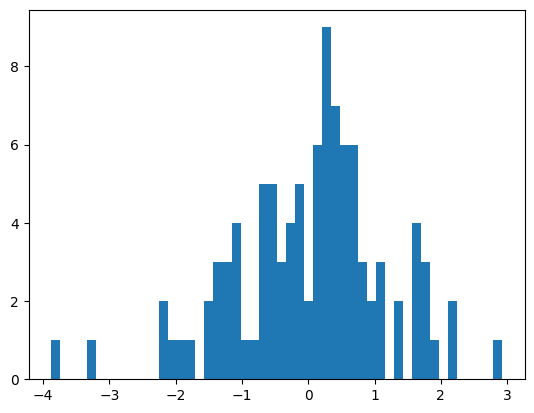

In [9]:
def bellshape_sample(mean, sd, n_samples, plot:bool=False, shuffle:bool=True):
    
    sample_pool = np.array([random.normalvariate(mean, sd) for sample in range(n_samples)])
    
    if shuffle:
        random.shuffle(sample_pool)
    else:
        sample_pool.sort()
    if plot:
        plt.hist(sample_pool, bins=50)
    
    return list(sample_pool)


smp = bellshape_sample(0, 1, 100, plot=True, shuffle=False)
print(smp)
print(type(smp))

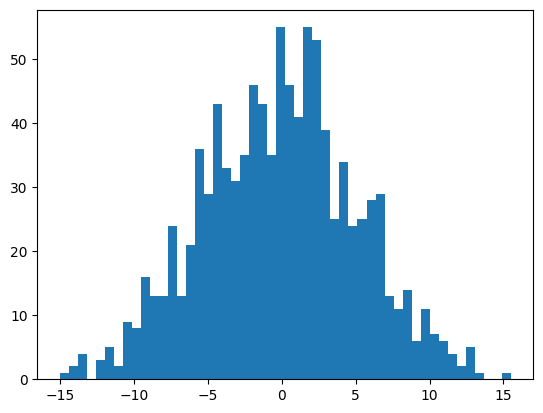

In [10]:
def bellshape_sample(mean, sd, n_samples, plot:bool=False):
    sample_pool = np.array([random.normalvariate(mean, sd) for sample in range(n_samples)])
    
    if plot:
        plt.hist(sample_pool, bins=50)
    return random.shuffle(sample_pool)


bellshape_sample(0, 5, 1000, True)



# # Randomly sample from gaussian distribution with mean and sd defined



# # veloc_pool = np.array([(random.uniform(0, 2)) for i in range(0, 500)])

# veloc_pool = np.array([(random.normalvariate(config["avg_ball_speed"], config["natural_speed_variance"])) for i in range(0, 500)])


# # plt.plot(list(range(0,100)), veloc_pool)

# plt.hist(veloc_pool, bins=100)

In [11]:
from functions.physics import _rotate_90, _dir_to_vec, _vec_to_dir, _flip_dir
from functions.utilities import determine_sequence
from functions.analysis import (get_precision, 
                                get_data, 
                                get_false_negatives,
                                get_false_positives,
                                get_true_positives,
                                get_true_negatives,
                                filter_condition,
                                get_f1_score, 
                                get_rt, 
                                get_accuracy,
                                get_hit_rate,)


In [12]:

from functions.utilities import check_balance, create_balanced_trial_design, build_design_matrix






design_matrix = build_design_matrix((192), True)

check_balance(design_matrix)
design_matrix

TypeError: 'bool' object is not iterable

In [15]:
1000//192

5*192

1000%192

100//192

0

In [186]:
from functions.utilities import check_balance, create_balanced_trial_design
# load in csv file as pd.dataframe
df = pd.read_csv('/Users/wiegerscheurer/repos/physicspred/data/sub-224750/ball_hue/design_matrix.csv')

check_balance(df)

Total trials: 144

Trial type balance:
trial_type
interactor    96
empty         48
Name: count, dtype: int64

Trial option balance for interactor trials:
trial_option
135_bottom_d    12
135_bottom_r    12
135_top_l       12
135_top_u       12
45_bottom_d     12
45_bottom_l     12
45_top_r        12
45_top_u        12
Name: count, dtype: int64
Variance: 0.00

Trial option balance for empty trials:
trial_option
none_d    12
none_l    12
none_r    12
none_u    12
Name: count, dtype: int64
Variance: 0.00

Bounce balance:
bounce
True     72
False    72
Name: count, dtype: int64

Ball change balance:
ball_change
True     72
False    72
Name: count, dtype: int64

Ball speed balance:
ball_speed
6.00    48
6.25    48
6.50    48
Name: count, dtype: int64

Cross-tabulation of trial_type × bounce:
bounce      False  True 
trial_type              
empty          24     24
interactor     48     48

Cross-tabulation of trial_type × ball_change:
ball_change  False  True 
trial_type               
emp

#### Acquire data per sub

In [24]:
# all_sub_names = ["wolpert", "wunger","scheur", "hendrik", "willem", "ikzelf", "melvin", "paulo", "yifan", "ann", "qifei", "mingyao", "bilge", "yanni", "eva"]
all_sub_names = ["002634"]
sub_stack = pd.DataFrame()

for sub_idx, sub in enumerate(all_sub_names):
    this_sub = get_data(subject=f"sub-{sub}", task="ball_hue")
    sub_stack = pd.concat([sub_stack, this_sub])
    
sub_stack.reset_index(inplace=True, drop=True)
# sub_stack

In [135]:
this_sub = random.choice(all_sub_names)
print(this_sub)
sub = get_data(subject=f"sub-{this_sub}", task="ball_hue")

simc_xpolc = get_rt(df=sub, sim_con=True, expol_con=True, return_df=True)["rt"]
simc_xpoli = get_rt(df=sub, sim_con=True, expol_con=False, return_df=True)["rt"]
simi_xpolc = get_rt(df=sub, sim_con=False, expol_con=True, return_df=True)["rt"]
simi_xpoli = get_rt(df=sub, sim_con=False, expol_con=False, return_df=True)["rt"]


all_kinds = [simc_xpolc, simc_xpoli, simi_xpolc, simi_xpoli]

for kind in all_kinds:
    print(len(kind))
    print(kind.mean(), kind.std())


bilge


FileNotFoundError: [Errno 2] No such file or directory: '/Users/wiegerscheurer/repos/physicspred/data/sub-bilge/ball_hue/'

#### Integrate in pilot script

In [26]:
sim_cons = [True, False]
expol_cons = [True, False]
# randsub = random.choice(all_sub_names)
randsub = "002634"
print(f"Now looking at : {randsub}")
for sim_con in sim_cons:
    
    for expol_con in expol_cons:
        
        print(f"sim_con: {sim_con}, expol_con: {expol_con}")
        dat = get_data(subject=f"sub-{randsub}", task="ball_hue")
        dat_filt = dat[(dat["sim_congruent"] == sim_con) & (dat["abs_congruent"] == expol_con)]
        print(len(dat_filt))

Now looking at : 002634
sim_con: True, expol_con: True


FileNotFoundError: [Errno 2] No such file or directory: '/Users/wiegerscheurer/repos/physicspred/data/sub-002634/ball_hue/'

In [192]:
wie = get_data(subject="sub-224750", task="ball_hue")

n_targets = len(wie[wie["ball_change"] == 1]) # 20
n_nones = len(wie[wie["interactor"] == "none_d"])# 20
n_nones

# sort dataframe based on trials column
wie.sort_values(by="interactor", inplace=True)

wie["response"]

15      NaN
100    left
102     NaN
43     left
48      NaN
       ... 
115      up
124      up
116    left
62      NaN
70     left
Name: response, Length: 144, dtype: object

In [193]:
wie

,trial_type,trial,ball_speed,interactor,bounce,bounce_moment,random_bounce_direction,target_onset,ball_change,target_color,...,start_pos,end_pos,abs_rfup,abs_rfright,abs_rfdown,abs_rfleft,sim_rfup,sim_rfright,sim_rfdown,sim_rfleft
15,interactor,16,6.00,135_bottom_d,True,3.980140,NaN,NaN,False,NaN,...,up,left,"(0, 0)","(0, 0)","(1, 0)","(0, 1)","(0, 0)","(0, 0)","(0, 0)","(1, 1)"
100,interactor,101,6.00,135_bottom_d,True,4.166790,NaN,4.432431,True,[0.45 0.45 0.695],...,up,left,"(0, 0)","(0, 0)","(1, 0)","(0, 1)","(0, 0)","(0, 0)","(0, 0)","(1, 1)"
102,interactor,103,6.25,135_bottom_d,True,3.950836,NaN,NaN,False,NaN,...,up,left,"(0, 0)","(0, 0)","(1, 0)","(0, 1)","(0, 0)","(0, 0)","(0, 0)","(1, 1)"
43,interactor,44,6.25,135_bottom_d,True,3.949038,NaN,4.217447,True,[0.45 0.45 0.695],...,up,left,"(0, 0)","(0, 0)","(1, 0)","(0, 1)","(0, 0)","(0, 0)","(0, 0)","(1, 1)"
48,interactor,49,6.00,135_bottom_d,False,NaN,NaN,NaN,False,NaN,...,up,down,"(0, 0)","(0, 0)","(1, 1)","(0, 0)","(0, 0)","(0, 0)","(0, 1)","(1, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,empty,116,6.00,none_u,False,NaN,NaN,NaN,False,NaN,...,down,up,"(1, 1)","(0, 0)","(0, 0)","(0, 0)","(1, 1)","(0, 0)","(0, 0)","(0, 0)"
124,empty,125,6.50,none_u,False,NaN,NaN,4.225236,True,[0.45 0.45 0.695],...,down,up,"(1, 1)","(0, 0)","(0, 0)","(0, 0)","(1, 1)","(0, 0)","(0, 0)","(0, 0)"
116,empty,117,6.25,none_u,True,3.942658,left,4.208010,True,[0.45 0.45 0.695],...,down,left,"(1, 0)","(0, 0)","(0, 0)","(0, 1)","(1, 0)","(0, 0)","(0, 0)","(0, 1)"
62,empty,63,6.25,none_u,True,3.951371,left,NaN,False,NaN,...,down,left,"(1, 0)","(0, 0)","(0, 0)","(0, 1)","(1, 0)","(0, 0)","(0, 0)","(0, 1)"


In [27]:

hit_rate = get_hit_rate(wie, False, False)
print(hit_rate)
wie_filt = filter_condition(wie, False, False)

fp = get_false_positives(wie_filt)
fn = get_false_negatives(wie_filt)
tp = get_true_positives(wie_filt)
tn = get_true_negatives(wie_filt)


print(f"False positives: {fp}")
print(f"False negatives: {fn}")
print(f"True positives: {tp}")
print(f"True negatives: {tn}")


hr = (tp) / (tp + fn)

hr
# get_misses(filter_condition(wie, False, False))

0.8787878787878788
False positives: 5
False negatives: 4
True positives: 29
True negatives: 26


0.8787878787878788

In [195]:
for sim_con in [True, False]:
    for xpol_con in [True, False]:
        print(f"sim_con: {sim_con}, xpol_con: {xpol_con}")
        print(f"{get_hit_rate(wie, sim_con, xpol_con):.2f}\n")

sim_con: True, xpol_con: True
1.00

sim_con: True, xpol_con: False
1.00

sim_con: False, xpol_con: True
1.00

sim_con: False, xpol_con: False
0.92



In [196]:
cc = filter_condition(wie, True, True)
ci = filter_condition(wie, True, False)
ic = filter_condition(wie, False, True)
ii = filter_condition(wie, False, False)

cc_targets = cc[cc["ball_change"] == 1]
ci_targets = ci[ci["ball_change"] == 1]
ic_targets = ic[ic["ball_change"] == 1]
ii_targets = ii[ii["ball_change"] == 1]

print(f"cc targets: {len(cc_targets)}")
print(f"ci targets: {len(ci_targets)}")
print(f"ic targets: {len(ic_targets)}")
print(f"ii targets: {len(ii_targets)}")

print(f"cc: {len(cc)}")
print(f"ci: {len(ci)}")
print(f"ic: {len(ic)}")
print(f"ii: {len(ii)}")


cc targets: 12
ci targets: 24
ic targets: 24
ii targets: 12
cc: 24
ci: 48
ic: 48
ii: 24


In [28]:
allen = get_data(subject=None, task="ball_hue")
# allen = get_data(subject="sub-224750", task="ball_hue")

In [29]:
hr = get_hit_rate(df=allen, sim_con=True, expol_con=True, return_df=True)["accuracy"]
hr

pr = get_precision(df=allen, sim_con=True, expol_con=True, return_df=True)["accuracy"]
pr




32      True
37      True
47      True
48      True
63      True
70      True
82      True
88      True
107     True
125     True
126     True
128     True
144     True
148    False
150     True
168     True
185    False
197     True
209     True
217     True
228     True
249     True
264    False
266    False
267    False
272    False
275     True
283    False
298    False
299    False
303     True
305     True
307     True
308     True
311     True
315     True
330     True
350     True
Name: accuracy, dtype: object

In [31]:
# for this_name in all_sub_names:
    # wie = get_data(subject=f"sub-{this_name}", task="ball_hue")
wie = allen

# Get hit rates for each condition
# simc_xpolc = get_hit_rate(df=wie, sim_con=True, expol_con=True, return_df=True)["accuracy"]
# simc_xpoli = get_hit_rate(df=wie, sim_con=True, expol_con=False, return_df=True)["accuracy"]
# simi_xpolc = get_hit_rate(df=wie, sim_con=False, expol_con=True, return_df=True)["accuracy"]
# simi_xpoli = get_hit_rate(df=wie, sim_con=False, expol_con=False, return_df=True)["accuracy"]

simc_xpolc = get_precision(df=wie, sim_con=True, expol_con=True, return_df=True)["accuracy"] # WHy doesn't this work?
simc_xpoli = get_precision(df=wie, sim_con=True, expol_con=False, return_df=True)["accuracy"]
simi_xpolc = get_precision(df=wie, sim_con=False, expol_con=True, return_df=True)["accuracy"]
simi_xpoli = get_precision(df=wie, sim_con=False, expol_con=False, return_df=True)["accuracy"]

cc_rt = get_rt(df=wie, sim_con=True, expol_con=True, return_df=False)
ci_rt = get_rt(df=wie, sim_con=True, expol_con=False, return_df=False)
ic_rt = get_rt(df=wie, sim_con=False, expol_con=True, return_df=False)
ii_rt = get_rt(df=wie, sim_con=False, expol_con=False, return_df=False)

print(f"Subject missed {get_false_negatives(wie)} trials")
# print(f"simc_xpolc: {simc_xpolc.mean()}, simc_xpoli: {simc_xpoli.mean()}, simi_xpolc: {simi_xpolc.mean()}, simi_xpoli: {simi_xpoli.mean()}")

# Create data for the 2x2 heatmap
z_values = [[simc_xpolc.mean(), simc_xpoli.mean()], 
            [simi_xpolc.mean(), simi_xpoli.mean()]]

# Create a figure with subplot for heatmap
fig = go.Figure()

# Add heatmap
fig.add_trace(go.Heatmap(
    z=z_values,
    x=['Congruent', 'Incongruent'],
    y=['Congruent', 'Incongruent'],
    text=[[f"{simc_xpolc.mean():.3f}<br>#trials: {len(simc_xpolc)}<br>rt: {cc_rt:.2f}s", f"{simc_xpoli.mean():.3f}<br>#trials: {len(simc_xpoli)}<br>rt: {ci_rt:.2f}s"], 
        [f"{simi_xpolc.mean():.3f}<br>#trials: {len(simi_xpolc)}<br>rt: {ic_rt:.2f}s", f"{simi_xpoli.mean():.3f}<br>#trials: {len(simi_xpoli)}<br>rt: {ii_rt:.2f}s"]],
    texttemplate="%{text}",
    textfont={"size":14},
    colorscale="magma_r",
    showscale=True,
    colorbar=dict(title="Hit Rate"),
    zmin=0,  # Set minimum value for the color scale
    zmax=1   # Set maximum value for the color scale
))

# Update layout
fig.update_layout(
    title=f"Hit Rate by Condition",
    xaxis=dict(title="Motion Extrapolation", side="bottom"),
    yaxis=dict(title="Simulation"),
    width=600,
    height=500
)

# Show the figure
fig.show()

Subject missed 9 trials


In [32]:

# Create an empty list to store all data frames
all_data = []

# Define types and their colors
types = ['Simcon + Xpolcon', 'Simcon + Xpolinc', 'Siminc + Xpolcon', 'Siminc + Xpolinc']

# Generate a colormap
cmap = plt.get_cmap('YlOrRd')  # You can choose a different colormap if you prefer
col_factor = 50
col_icept = 150
# Create the colors dictionary
type_colors = {name: f'rgba({int(cmap(i*col_factor + col_icept)[0]*255)}, {int(cmap(i*col_factor + col_icept)[1]*255)}, {int(cmap(i*col_factor + col_icept)[2]*255)}, 0.5)' 
          for i, name in enumerate(types)}

# Loop through all subjects (using the same structure as your original code)
# for sub_name in all_sub_names:
# for sub_name in ["139166"]:
for sub_name in ["allen"]:
    # sub = get_data(subject=f"{sub_name}", task="ball_hue")
    sub = allen
    simc_xpolc = get_rt(df=sub, sim_con=True, expol_con=True, return_df=True)["rt"]
    simc_xpoli = get_rt(df=sub, sim_con=True, expol_con=False, return_df=True)["rt"]
    simi_xpolc = get_rt(df=sub, sim_con=False, expol_con=True, return_df=True)["rt"]
    simi_xpoli = get_rt(df=sub, sim_con=False, expol_con=False, return_df=True)["rt"]
    
    # Create DataFrames without subject column - we'll aggregate across all subjects
    simc_xpolc_df = pd.DataFrame({
        'Reaction Time': simc_xpolc,
        'Type': 'Simcon + Xpolcon'
    })
    
    simc_xpoli_df = pd.DataFrame({
        'Reaction Time': simc_xpoli,
        'Type': 'Simcon + Xpolinc'
    })
    
    simi_xpolc_df = pd.DataFrame({
        'Reaction Time': simi_xpolc,
        'Type': 'Siminc + Xpolcon'
    })
    
    simi_xpoli_df = pd.DataFrame({
        'Reaction Time': simi_xpoli,
        'Type': 'Siminc + Xpolinc'
    })
    
    # Append all DataFrames to our list
    all_data.extend([simc_xpolc_df, simc_xpoli_df, simi_xpolc_df, simi_xpoli_df])

# Combine all the data into a single DataFrame
combined_data = pd.concat(all_data, ignore_index=True)

# Calculate mean reaction time for each type
type_means = combined_data.groupby('Type')['Reaction Time'].mean().to_dict()

# Create the plot
fig = go.Figure()

# Add violin plots for each type
for i, type_name in enumerate(types):
    subset = combined_data[combined_data['Type'] == type_name]
    
    fig.add_trace(go.Violin(
        x=[type_name] * len(subset),  # Use type name directly as x value
        y=subset['Reaction Time'],
        name=type_name,
        legendgroup=type_name,
        showlegend=True,
        box_visible=True,
        meanline_visible=True,
        points='all',
        jitter=0.2,
        pointpos=0.5,
        line_color=type_colors[type_name],
        side='negative',
        width=.5,
        spanmode='soft'
    ))

# Connect the means with a line
fig.add_trace(go.Scatter(
    x=types,
    y=[type_means[t] for t in types],
    mode='lines+markers',
    line=dict(color='rgba(0, 0, 0, 0.7)', width=8),
    marker=dict(
        size=14,  # Increased marker size
        color=[type_colors[t].replace('0.5', '1') for t in types],
        line=dict(color='black', width=4)
    ),
    name='Mean RT',
    hovertemplate='Mean: %{y:.3f}s<extra></extra>'
))

# Define a common font style for consistent text appearance
font_style = dict(
    family="Arial, sans-serif",
    size=20,  # Larger font size
    color="black"
)

# Update layout with enhanced text styling
fig.update_layout(
    title=dict(
        text="Average Reaction Times Across All Subjects\n\n",
        font=dict(size=25, family="Arial, sans-serif", color="black"),
        x=0.5,
        y=.985
    ),
    yaxis=dict(
        title=dict(
            text="Reaction Time (s)",
            font=font_style
        ),
        tickfont=font_style,
        tickwidth=2,
        showline=True,
        linewidth=3,
        linecolor='black'
    ),
    xaxis=dict(
        title=dict(
            text="Response Type",
            font=font_style
        ),
        tickmode='array',
        tickvals=types,
        tickfont=font_style,
        tickwidth=2,
        showline=True,
        linewidth=3,
        linecolor='black'
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.01,
        xanchor="center",
        x=0.5,
        font=dict(size=18, family="Arial, sans-serif"),
        borderwidth=2,
        bordercolor="White",
        title=dict(
            text="Response Type",
            font=dict(size=18, family="Arial, sans-serif")
        )
    ),
    violinmode='overlay',
    # height=1200,
    # width=1200,
    height=1200,
    width=1200,
    font=font_style,  # Default font for all other text elements
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Add annotations for the mean values
for i, type_name in enumerate(types):
    fig.add_annotation(
        x=type_name,
        y=type_means[type_name],
        text=f"{type_means[type_name]:.3f}s",
        showarrow=True,
        arrowhead=2,
        arrowsize=1.5,  # Slightly larger arrowhead
        arrowwidth=3,    # Thicker arrow
        arrowcolor='black',
        ax=120,
        ay=-90,
        font=dict(size=25, color='black', family="Arial, sans-serif")
    )

# Make the axis lines thicker
fig.update_xaxes(mirror=True, ticks='outside', tickwidth=3, ticklen=10, showgrid=False)
fig.update_yaxes(mirror=True, ticks='outside', tickwidth=3, ticklen=10, showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()




In [34]:

# Create an empty list to store all data frames
all_data = []

# Define types and their colors
types = ['Abstraction', 'Simulation', 'Both']

# Generate a colormap
cmap = plt.get_cmap('YlOrRd')  # You can choose a different colormap if you prefer
col_factor = 50
col_icept = 150
# Create the colors dictionary
type_colors = {name: f'rgba({int(cmap(i*col_factor + col_icept)[0]*255)}, {int(cmap(i*col_factor + col_icept)[1]*255)}, {int(cmap(i*col_factor + col_icept)[2]*255)}, 0.5)' 
          for i, name in enumerate(types)}

# Loop through all subjects (using the same structure as your original code)
for sub_name in all_sub_names:
    sub = get_data(subject=f"sub-{sub_name}", task="ball_hue")
    # Get your data as before
    rt_dubs = get_rt(sub, hypothesis="both", include_dubtrials="only", return_df=True)
    rt_separate = get_rt(sub, hypothesis="both", include_dubtrials=False, return_df=True)
    sim_rt = rt_separate["simulation"]["rt"]
    abs_rt = rt_separate["abstraction"]["rt"]
    both_rt = rt_dubs["sim + abs"]["rt"]
    
    # Create DataFrames without subject column - we'll aggregate across all subjects
    sim_df = pd.DataFrame({
        'Reaction Time': sim_rt,
        'Type': 'Simulation'
    })
    
    abs_df = pd.DataFrame({
        'Reaction Time': abs_rt,
        'Type': 'Abstraction'
    })
    
    both_df = pd.DataFrame({
        'Reaction Time': both_rt,
        'Type': 'Both'
    })
    
    # Append all DataFrames to our list
    all_data.extend([abs_df, sim_df, both_df])

# Combine all the data into a single DataFrame
combined_data = pd.concat(all_data, ignore_index=True)

# Calculate mean reaction time for each type
type_means = combined_data.groupby('Type')['Reaction Time'].mean().to_dict()

# Create the plot
fig = go.Figure()

# Add violin plots for each type
for i, type_name in enumerate(types):
    subset = combined_data[combined_data['Type'] == type_name]
    
    fig.add_trace(go.Violin(
        x=[type_name] * len(subset),  # Use type name directly as x value
        y=subset['Reaction Time'],
        name=type_name,
        legendgroup=type_name,
        showlegend=True,
        box_visible=True,
        meanline_visible=True,
        points='all',
        jitter=0.2,
        pointpos=0.5,
        line_color=type_colors[type_name],
        side='negative',
        width=.5,
        spanmode='soft'
    ))

# Connect the means with a line
fig.add_trace(go.Scatter(
    x=types,
    y=[type_means[t] for t in types],
    mode='lines+markers',
    line=dict(color='rgba(0, 0, 0, 0.7)', width=8),
    marker=dict(
        size=14,  # Increased marker size
        color=[type_colors[t].replace('0.5', '1') for t in types],
        line=dict(color='black', width=4)
    ),
    name='Mean RT',
    hovertemplate='Mean: %{y:.3f}s<extra></extra>'
))

# Define a common font style for consistent text appearance
font_style = dict(
    family="Arial, sans-serif",
    size=20,  # Larger font size
    color="black"
)

# Update layout with enhanced text styling
fig.update_layout(
    title=dict(
        text="Average Reaction Times Across All Subjects\n\n",
        font=dict(size=25, family="Arial, sans-serif", color="black"),
        x=0.5,
        y=.985
    ),
    yaxis=dict(
        title=dict(
            text="Reaction Time (s)",
            font=font_style
        ),
        tickfont=font_style,
        tickwidth=2,
        showline=True,
        linewidth=3,
        linecolor='black'
    ),
    xaxis=dict(
        title=dict(
            text="Response Type",
            font=font_style
        ),
        tickmode='array',
        tickvals=types,
        tickfont=font_style,
        tickwidth=2,
        showline=True,
        linewidth=3,
        linecolor='black'
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.01,
        xanchor="center",
        x=0.5,
        font=dict(size=18, family="Arial, sans-serif"),
        borderwidth=2,
        bordercolor="White",
        title=dict(
            text="Response Type",
            font=dict(size=18, family="Arial, sans-serif")
        )
    ),
    violinmode='overlay',
    # height=1200,
    # width=1200,
    height=800,
    width=800,
    font=font_style,  # Default font for all other text elements
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Add annotations for the mean values
for i, type_name in enumerate(types):
    fig.add_annotation(
        x=type_name,
        y=type_means[type_name],
        text=f"{type_means[type_name]:.3f}s",
        showarrow=True,
        arrowhead=2,
        arrowsize=1.5,  # Slightly larger arrowhead
        arrowwidth=3,    # Thicker arrow
        arrowcolor='black',
        ax=120,
        ay=-90,
        font=dict(size=25, color='black', family="Arial, sans-serif")
    )

# Make the axis lines thicker
fig.update_xaxes(mirror=True, ticks='outside', tickwidth=3, ticklen=10, showgrid=False)
fig.update_yaxes(mirror=True, ticks='outside', tickwidth=3, ticklen=10, showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()